## Preprocessing

In [1]:
from nilearn import plotting
%matplotlib inline
import os
import json
from nipype.interfaces import fsl 
from nipype.interfaces import spm
from nipype.interfaces.spm import (Realign, SliceTiming, Coregister,  NewSegment,  Normalize12, Smooth)
from nipype.interfaces import matlab as mlab
from nipype.interfaces.io import SelectFiles, DataSink
import nipype.interfaces.utility as util 
from nipype.algorithms import rapidart as ra
from nipype.interfaces.utility import IdentityInterface
import nipype.pipeline.engine as pe
import nipype.interfaces.io as nio
from nipype import DataGrabber, Workflow, Node

In [7]:
os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/'))

'/home/matay/Documents/MATLAB/spm12'

In [9]:
spm.SPMCommand.set_mlab_paths(paths=os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/')), matlab_cmd='/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB -nodesktop -nosplash')

stty: 'standard input': Inappropriate ioctl for device


In [10]:
mlab.MatlabCommand.set_default_matlab_cmd("/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB  -nodesktop -nosplash")
mlab.MatlabCommand.set_default_paths(os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/')))

In [4]:
# spm.SPMCommand().version

In [11]:
fsl.FSLCommand.set_default_output_type('NIFTI')

In [12]:
base_dir = os.path.join(os.environ['HOME'], 'spmbasics/data/')

In [13]:
experiment_dir = os.path.join(base_dir, 'output')
data_dir = os.path.abspath(os.path.join(base_dir, 'face_rep'))
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['M03953']
# below info referred by datagrabber needs to be referred within infosource, selectfiles 
info = dict(
    func=[['RawEPI', 'subject_id', 5, ["_%04d" % i for i in range(6, 357)]]],
    struct=[['Structural', 'subject_id', 7, '']])

# TR of functional images
#TR = 2.
# Smoothing width used during preprocessing
fwhm = [8]

In [14]:
infosource = Node(IdentityInterface(fields=['subject_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list)]

In [15]:
datasource = Node(
    interface=DataGrabber(
        infields=['subject_id'], outfields=['func', 'struct']),
    name='datasource')
datasource.inputs.base_directory = data_dir
datasource.inputs.template = '%s/s%s_%04d%s.img'
datasource.inputs.template_args = info
datasource.inputs.sort_filelist = True

In [16]:
merge = Node(interface=fsl.Merge(), name="merge")
merge.inputs.dimension = "t" 
merge.inputs.output_type = 'NIFTI'

In [17]:
realigner = Node(interface=Realign(), name='realign')
# realigner.inputs.in_files = func_file
realigner.inputs.register_to_mean = True
realigner.inputs.fwhm = 5
realigner.inputs.interp = 2
realigner.inputs.quality = 0.9
realigner.inputs.separation = 4
realigner.inputs.wrap = [0, 0, 0]
realigner.inputs.write_which = [2, 1]
realigner.inputs.write_interp = 4 
realigner.inputs.write_wrap = [0, 0, 0]
realigner.inputs.write_mask = True
realigner.inputs.jobtype = 'estwrite'
realigner.inputs.out_prefix = 'r'

In [18]:
slicetiming = Node(interface=SliceTiming(), name = 'slicetiming')
# st.inputs.in_files = anat_file
slicetiming.inputs.num_slices = 24
slicetiming.inputs.time_repetition = 2.
slicetiming.inputs.time_acquisition = 1.92
slicetiming.inputs.slice_order = list(range(24,0,-1))
slicetiming.inputs.ref_slice = 12
slicetiming.inputs.out_prefix = 'a'

In [19]:
coregister = Node(Coregister(), name="coregister")
coregister.inputs.jobtype = 'estimate'
coregister.inputs.cost_function = 'nmi'
coregister.inputs.fwhm = [7.0, 7.0]
coregister.inputs.separation = [4.0, 2.0]
coregister.inputs.tolerance = [0.02, 0.02, 0.02, 0.001, 0.001, 0.001, 0.01, 0.01, 0.01, 0.001, 0.001, 0.001]

In [20]:
tpm_path = os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/tpm/', 'TPM.nii'))

In [21]:
segment =  Node(NewSegment(), name="newsegment")
# seg.inputs.channel_files = '/data/preproc/coregister/sub-01_T1w.nii'
#seg.inputs.channel_files = '/data/MoAEpilot_raw/sub-01/anat/sub-01_T1w.nii'
segment.inputs.affine_regularization = 'mni'
segment.inputs.channel_info = (0.001, 60, (False, True)) #save bias corrected map
tissue1 = ((tpm_path, 1), 1, (True, False), (False, False))
tissue2 = ((tpm_path, 2), 1, (True, False), (False, False))
tissue3 = ((tpm_path, 3), 2, (True, False), (False, False))
tissue4 = ((tpm_path, 4), 3, (True, False), (False, False))
tissue5 = ((tpm_path, 5), 4, (True, False), (False, False))
tissue6 = ((tpm_path, 6), 2, (False, False), (False, False))
segment.inputs.tissues = [tissue1, tissue2, tissue3, tissue4, tissue5, tissue6]
segment.inputs.warping_regularization = [0, 0.001, 0.5, 0.05, 0.2]
segment.inputs.sampling_distance = 3
segment.inputs.write_deformation_fields = [False, True] 

stty: 'standard input': Inappropriate ioctl for device


In [22]:
normalize = Node(Normalize12(), name="normalize") 
normalize.inputs.jobtype = 'write'
normalize.inputs.write_bounding_box =  [[-78, -112, -70], [78, 76, 85]]
normalize.inputs.write_voxel_sizes = [3, 3, 3]
normalize.inputs.write_interp = 4
normalize.inputs.out_prefix = 'w'

In [23]:
smooth = Node(Smooth(), name="smooth")
smooth.inputs.fwhm = [8, 8, 8]
smooth.inputs.data_type = 0
smooth.inputs.implicit_masking = False
smooth.inputs.out_prefix = 's'

In [24]:
sink = Node(interface=DataSink(),
                   name='sink')
sink.inputs.base_directory = os.path.join(base_dir, 'output')

In [25]:
preproc = Workflow(name='event_preproc')
preproc.base_dir = os.path.join(experiment_dir, working_dir)

In [26]:
def get_vox_dims(volume):
    import nibabel as nb
    if isinstance(volume, list):
        volume = volume[0]
    nii = nb.load(volume)
    hdr = nii.header
    voxdims = hdr.get_zooms()
    return [float(voxdims[0]), float(voxdims[1]), float(voxdims[2])]

In [27]:
preproc.connect([(infosource, datasource, [('subject_id', 'subject_id')]),
                 (datasource, merge, [('func', 'in_files')]),
                 (merge, sink, [('merged_file', 'preproc.@merged_file')]),
                 (merge, realigner, [('merged_file', 'in_files')]),
                 (realigner, slicetiming, [('realigned_files', 'in_files')]),
                 (realigner, coregister, [('mean_image', 'source'), 
                                          ('realigned_files', 'apply_to_files')]),
                 (realigner, sink, [('realignment_parameters', 'preproc.@realignement_parameters')]),
                 (datasource, coregister, [('struct', 'target')]), 
                 (coregister, sink, [('coregistered_source', 'preproc.@coregisered_source')]),
                 (coregister, segment, [('coregistered_source', 'channel_files')]),
                 (segment, sink, [('bias_corrected_images', 'preproc.@bias_corrected_images'), 
                                 ('transformation_mat', 'preproc.@transformation_mat'),
                                 ('native_class_images', 'preproc.@native_class_images')]),
                 (segment, normalize, [('forward_deformation_field', 'deformation_file')]),
                 (slicetiming, normalize, [('timecorrected_files', 'apply_to_files'),
                                          (('timecorrected_files', get_vox_dims),
                                     'write_voxel_sizes')]),
                 (normalize, smooth, [('normalized_files', 'in_files')]),
])

In [28]:
preproc.write_graph(graph2use='colored', format='png', dotfilename='colored_graph.dot', simple_form=True)

240516-16:42:13,447 nipype.workflow INFO:
	 Generated workflow graph: /home/matay/spmbasics/data/output/workingdir/event_preproc/colored_graph.png (graph2use=colored, simple_form=True).


'/home/matay/spmbasics/data/output/workingdir/event_preproc/colored_graph.png'

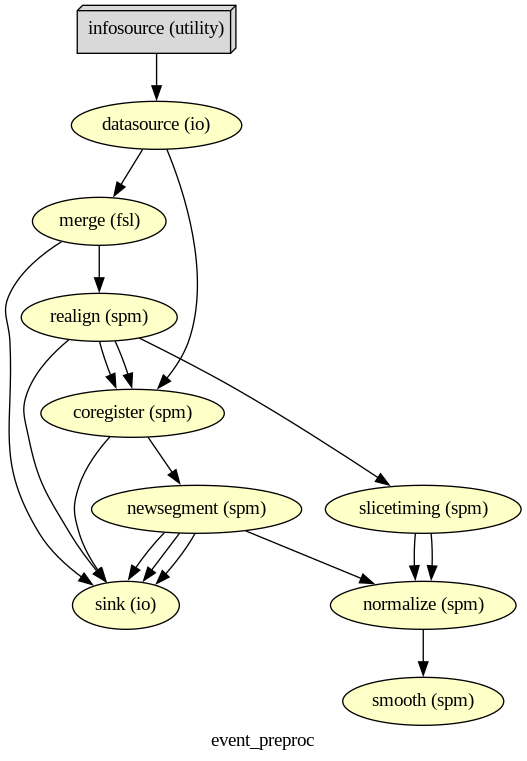

In [33]:
# Visualize the graph
from IPython.display import Image
Image(filename='./spmbasics/data/output/workingdir/event_preproc/colored_graph.png', width=750)

In [29]:
preproc.write_graph(graph2use='flat', format='png', simple_form=True, dotfilename='flat_graph.dot')

240516-16:42:20,593 nipype.workflow INFO:
	 Generated workflow graph: /home/matay/spmbasics/data/output/workingdir/event_preproc/flat_graph.png (graph2use=flat, simple_form=True).


'/home/matay/spmbasics/data/output/workingdir/event_preproc/flat_graph.png'

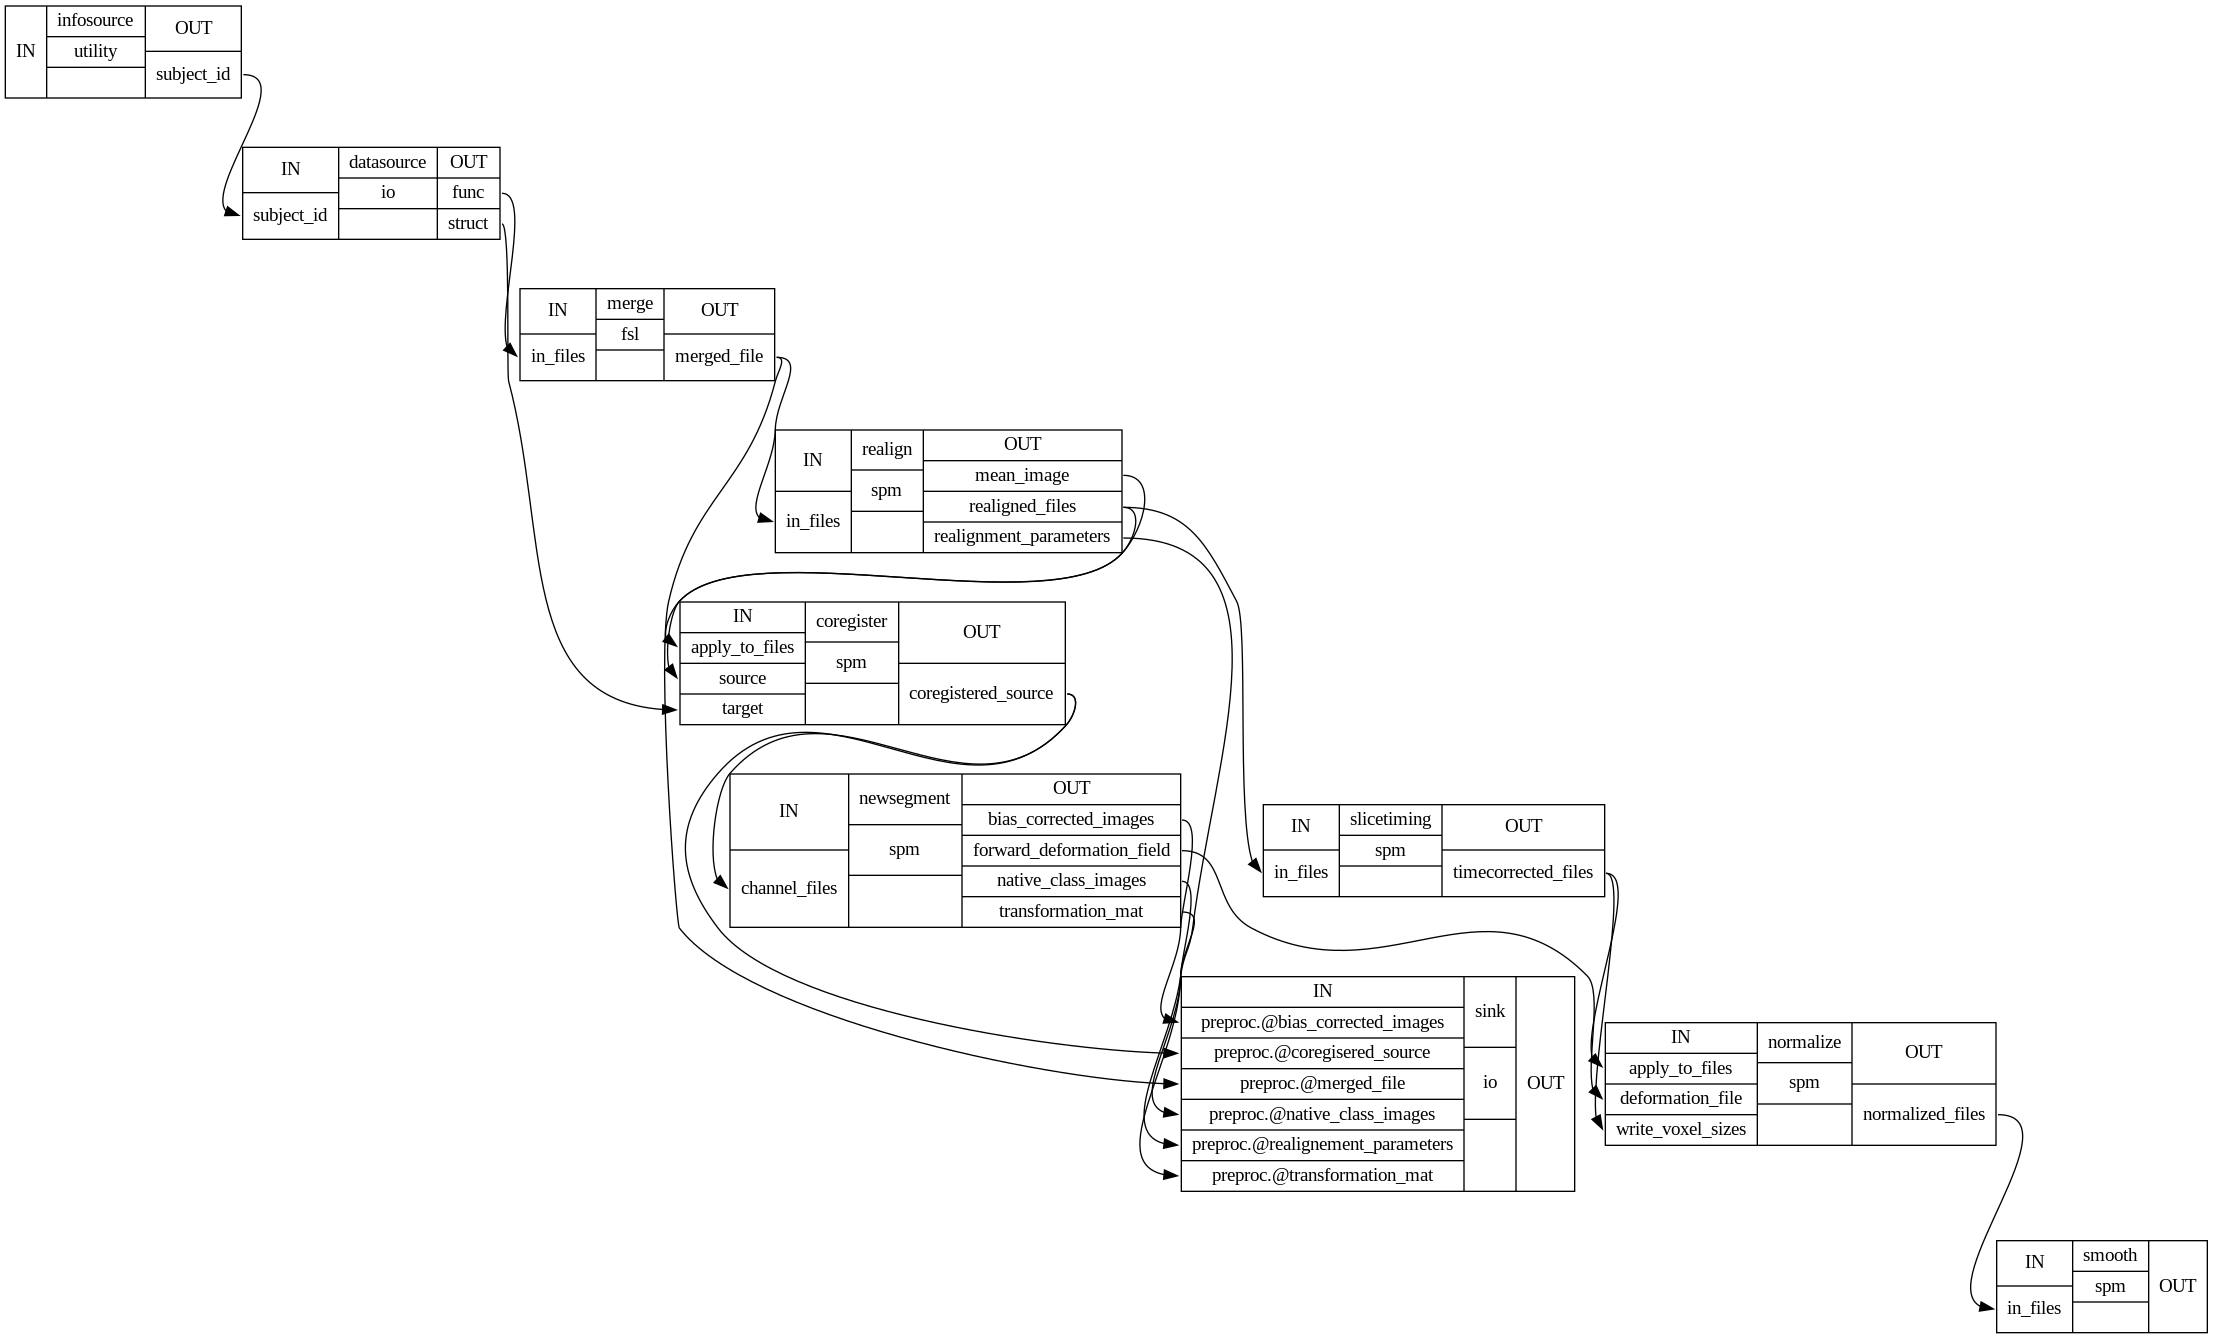

In [30]:
from IPython.display import Image
Image(filename='./spmbasics/data/output/workingdir/event_preproc/flat_graph_detailed.png' )

In [31]:
preproc.run()

240516-16:42:29,132 nipype.workflow INFO:
	 Workflow event_preproc settings: ['check', 'execution', 'logging', 'monitoring']
240516-16:42:29,139 nipype.workflow INFO:
	 Running serially.
240516-16:42:29,139 nipype.workflow INFO:
	 [Node] Setting-up "event_preproc.datasource" in "/home/matay/spmbasics/data/output/workingdir/event_preproc/_subject_id_M03953/datasource".
240516-16:42:29,142 nipype.workflow INFO:
	 [Node] Executing "datasource" <nipype.interfaces.io.DataGrabber>
240516-16:42:29,145 nipype.workflow INFO:
	 [Node] Finished "datasource", elapsed time 0.002513s.
240516-16:42:29,152 nipype.workflow INFO:
	 [Node] Setting-up "event_preproc.merge" in "/home/matay/spmbasics/data/output/workingdir/event_preproc/_subject_id_M03953/merge".
240516-16:42:29,166 nipype.workflow INFO:
	 [Node] Executing "merge" <nipype.interfaces.fsl.utils.Merge>
240516-16:42:29,729 nipype.workflow INFO:
	 [Node] Finished "merge", elapsed time 0.562282s.
240516-16:42:29,734 nipype.workflow INFO:
	 [Node]

stty: 'standard input': Inappropriate ioctl for device


240516-16:43:24,494 nipype.workflow INFO:
	 [Node] Finished "realign", elapsed time 48.229599s.
240516-16:43:24,501 nipype.workflow INFO:
	 [Node] Setting-up "event_preproc.slicetiming" in "/home/matay/spmbasics/data/output/workingdir/event_preproc/_subject_id_M03953/slicetiming".
240516-16:43:24,504 nipype.workflow INFO:
	 [Node] Executing "slicetiming" <nipype.interfaces.spm.preprocess.SliceTiming>


stty: 'standard input': Inappropriate ioctl for device


240516-16:43:40,835 nipype.workflow INFO:
	 [Node] Finished "slicetiming", elapsed time 16.331058s.
240516-16:43:40,838 nipype.workflow INFO:
	 [Node] Setting-up "event_preproc.coregister" in "/home/matay/spmbasics/data/output/workingdir/event_preproc/_subject_id_M03953/coregister".
240516-16:43:40,863 nipype.workflow INFO:
	 [Node] Executing "coregister" <nipype.interfaces.spm.preprocess.Coregister>


stty: 'standard input': Inappropriate ioctl for device


240516-16:44:10,705 nipype.workflow INFO:
	 [Node] Finished "coregister", elapsed time 29.840652s.
240516-16:44:10,725 nipype.workflow INFO:
	 [Node] Setting-up "event_preproc.newsegment" in "/home/matay/spmbasics/data/output/workingdir/event_preproc/_subject_id_M03953/newsegment".
240516-16:44:10,730 nipype.workflow INFO:
	 [Node] Executing "newsegment" <nipype.interfaces.spm.preprocess.NewSegment>


stty: 'standard input': Inappropriate ioctl for device


240516-16:44:33,666 nipype.workflow INFO:
	 [Node] Finished "newsegment", elapsed time 22.934488s.
240516-16:44:33,669 nipype.workflow INFO:
	 [Node] Setting-up "event_preproc.sink" in "/home/matay/spmbasics/data/output/workingdir/event_preproc/_subject_id_M03953/sink".
240516-16:44:33,674 nipype.workflow INFO:
	 [Node] Executing "sink" <nipype.interfaces.io.DataSink>
240516-16:44:33,678 nipype.workflow INFO:
	 [Node] Finished "sink", elapsed time 0.00246s.
240516-16:44:33,679 nipype.workflow INFO:
	 [Node] Setting-up "event_preproc.normalize" in "/home/matay/spmbasics/data/output/workingdir/event_preproc/_subject_id_M03953/normalize".
240516-16:44:33,710 nipype.workflow INFO:
	 [Node] Executing "normalize" <nipype.interfaces.spm.preprocess.Normalize12>


stty: 'standard input': Inappropriate ioctl for device


240516-16:44:53,715 nipype.workflow INFO:
	 [Node] Finished "normalize", elapsed time 20.004194s.
240516-16:44:53,725 nipype.workflow INFO:
	 [Node] Setting-up "event_preproc.smooth" in "/home/matay/spmbasics/data/output/workingdir/event_preproc/_subject_id_M03953/smooth".
240516-16:44:53,727 nipype.workflow INFO:
	 [Node] Executing "smooth" <nipype.interfaces.spm.preprocess.Smooth>


stty: 'standard input': Inappropriate ioctl for device


240516-16:45:09,620 nipype.workflow INFO:
	 [Node] Finished "smooth", elapsed time 15.892143s.


stty: 'standard input': Inappropriate ioctl for device
